In [1]:
#Numpy - for scientific computing
import numpy as np
import scipy

#For image reading and analysis
import glob
import skimage.io
import skimage.filters as sf
from skimage import io, measure, filters, transform, morphology

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import lmfit

# For loading bars
from tqdm.notebook import tqdm as tqdm

# For creating DataFrames
import pandas as pd

# Put all analyzed csv files into one dataframe

In [2]:
umperpixel = 0.161

In [3]:
#Import files and add the names as strings to an array
file_path = '../../analyzed_data/gliding/'
file_folder1 = '2023-07-10_Gliding/'
file_folder2 = '2023-07-11_Gliding/'
file_folder3 = '2023-07-12_Gliding/'
file_folder4 = '2023-08-11_Gliding/'
included_files = '*.csv'
dir1 = file_path+file_folder1+included_files
dir2 = file_path+file_folder2+included_files
dir3 = file_path+file_folder3+included_files
dir4 = file_path+file_folder4+included_files
files1=np.sort(glob.glob(dir1))
files2=np.sort(glob.glob(dir2))
files3=np.sort(glob.glob(dir3))
files4=np.sort(glob.glob(dir4))
files=np.concatenate((files1, files2, files3, files4))

#Convert file names to a dataframe
dfs = []
for file in files:
    temp_df=pd.read_csv(file)
    #add a column of file names
    temp_df['file_name']=file.split('/')[-1]
    dfs.append(temp_df)
df=pd.concat(dfs)

#Add columns for the motor and MT conncentration and time of aquisition
zeros = np.zeros(len(df))
df['motor conc'] = zeros
df['MT dilute'] = zeros
df['time (seconds)'] = zeros
df['group'] = zeros

#reset the index and drop any extraneous columns
df=df.reset_index()
df=df.drop(columns=['Unnamed: 0', 'level_0'])

In [4]:
df

,index,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,label,speed (nm/s),r^2,skele r^2,MT len (um),file_name,motor conc,MT dilute,time (seconds),group
0,0,22,29.274002,1.345232,22.590909,69.500000,-1.048308,3,48.501008,0.935167,0.794997,2.287222,2023-07-10_Gliding_ATP1410um_2-start0_stop50.csv,0.0,0.0,0.0,0.0
1,3,31,43.444095,1.429147,37.322581,443.000000,-0.967216,6,52.830420,0.976208,0.898563,4.158981,2023-07-10_Gliding_ATP1410um_2-start0_stop50.csv,0.0,0.0,0.0,0.0
2,4,21,25.161952,1.919222,45.000000,73.904762,0.275133,8,47.225378,0.982301,0.986687,2.264911,2023-07-10_Gliding_ATP1410um_2-start0_stop50.csv,0.0,0.0,0.0,0.0
3,5,37,42.814207,1.622051,55.000000,178.162162,0.070398,9,79.627012,0.946496,0.701686,3.807146,2023-07-10_Gliding_ATP1410um_2-start0_stop50.csv,0.0,0.0,0.0,0.0
4,7,32,36.971773,1.012663,71.500000,314.562500,0.046190,13,70.560714,0.846335,0.840947,2.647040,2023-07-10_Gliding_ATP1410um_2-start0_stop50.csv,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,23,32,36.984916,1.162046,300.281250,348.500000,-1.517458,56,49.413277,0.969330,0.779539,2.299088,2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1...,0.0,0.0,0.0,0.0
1610,24,50,58.510785,1.528927,331.500000,361.120000,0.164288,59,53.387059,0.950403,0.716102,6.250562,2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1...,0.0,0.0,0.0,0.0
1611,28,19,21.911077,1.927782,320.842105,134.000000,1.556653,65,59.269231,0.934272,0.924519,2.407771,2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1...,0.0,0.0,0.0,0.0
1612,30,12,15.624462,1.048051,356.583333,122.500000,-1.082633,73,19.030084,0.827658,0.828966,1.803357,2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1...,0.0,0.0,0.0,0.0


## define the motor and microtubule concentrations for the different files

In [5]:
#--------------- ATP = 1410 uM ----------------------#

# motor 0.33  MT 1:2000
group1=np.array(['2023-07-10_Gliding_ATP1410um_2',
        '2023-07-10_Gliding_ATP1410um_3',
        '2023-07-10_Gliding_ATP1410um_4',
        '2023-07-10_Gliding_ATP1410um_5',
        '2023-07-10_Gliding_ATP1410um_6',
        '2023-07-10_Gliding_ATP1410um_7',
        '2023-07-10_Gliding_ATP1410um_8',
        '2023-07-10_Gliding_ATP1410um_9',
        '2023-07-10_Gliding_ATP1410um_10',
        '2023-07-10_Gliding_ATP1410um_11',
       ])
# motor 0.25 MT 1:200
group2=np.array(['2023-07-11_Gliding_R3_ATP1410um_0.25iLid_1',
        '2023-07-11_Gliding_R3_ATP1410um_0.25iLid_2',
        '2023-07-11_Gliding_R3_ATP1410um_0.25iLid_3',
        '2023-07-11_Gliding_R3_ATP1410um_0.25iLid_4',
        '2023-07-11_Gliding_R3_ATP1410um_0.25iLid_5',
       ])
# motor 0.25 MT 1:600
group3=np.array(['2023-07-11_Gliding_R4_ATP1410um_0.25iLid_1',
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_2',
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_3',
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_4',
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_5',
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_6',
       ])
#motor 0.125 MT 1:200
group4=np.array(['2023-07-12_Gliding_R1_ATP1410um_0.125iLid_1',
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_2',
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_3',
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_4',
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_5',
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_6',
       ])
#motor 0.5 MT 1:4000
group5=np.array(['2023-07-12_Gliding_R2_ATP1410um_0.5iLid_1',
        '2023-07-12_Gliding_R2_ATP1410um_0.5iLid_2',
        '2023-07-12_Gliding_R2_ATP1410um_0.5iLid_3',
        '2023-07-12_Gliding_R2_ATP1410um_0.5iLid_4',
       ])

#motor 0.0625 MT 1:50
group6=np.array(['2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP_2',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-6min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-8min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-10.5min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-12.5min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-15min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-16.5min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-19.5min_1',
                ])

#motor 0.0625 MT 1:200
group7=np.array(['2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-6min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-7.5min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-9.5min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-12min_1',
                 '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-14.5min_1',
                ])

#motor 0.031 MT 1:200
group8=np.array(['2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-2min_1',
                '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-5.5min_1',
                '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-7.5min_1',
                '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-9.5min_1',
                '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-11min_1',
                '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-13min_1',
                '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-15min_1',
                '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-18min_1',
                ])

#---------- Varying ATP ---------#

#705uM ATP, motor 0.0625, MT 1:200
group9=np.array(['2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_7min_1',
                 '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_9min_1',
                 '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_11min_1',
                 '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_13min_1',
                 '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_16min_1',
                 '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_18min_1',
                 '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_20min_1',
                ])

#353uM ATP, motor 0.0625, MT 1:400
group10=np.array(['2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_1.5min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_4min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_5.5min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_7.5min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_9.5min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_11.5min_1',
                ])

#470uM ATP, motor 0.0625, MT 1:400
group11=np.array(['2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_3min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_4.5min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_7min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_9min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_11min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_13min_1',
                  '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_16min_1',
                ])

## define the times for the different files

In [6]:
times = {'2023-07-10_Gliding_ATP1410um_2':5*60,
        '2023-07-10_Gliding_ATP1410um_3':8*60,
        '2023-07-10_Gliding_ATP1410um_4':10*60,
        '2023-07-10_Gliding_ATP1410um_5':12*60,
        '2023-07-10_Gliding_ATP1410um_6':15*60,
        '2023-07-10_Gliding_ATP1410um_7':18*60,
        '2023-07-10_Gliding_ATP1410um_8':7*60,
        '2023-07-10_Gliding_ATP1410um_9':10*60,
        '2023-07-10_Gliding_ATP1410um_10':12.5*60,
        '2023-07-10_Gliding_ATP1410um_11':15.5*60,
        '2023-07-11_Gliding_R3_ATP1410um_0.25iLid_1':2.5*60,
        '2023-07-11_Gliding_R3_ATP1410um_0.25iLid_2':5*60,
        '2023-07-11_Gliding_R3_ATP1410um_0.25iLid_3':7*60,
        '2023-07-11_Gliding_R3_ATP1410um_0.25iLid_4':10.5*60,
        '2023-07-11_Gliding_R3_ATP1410um_0.25iLid_5':14*60,
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_1':2*60,
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_2':6.5*60,
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_3':8.5*60,
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_4':11*60,
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_5':13.5*60,
        '2023-07-11_Gliding_R4_ATP1410um_0.25iLid_6':16*60,
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_1':2*60,
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_2':4.5*60,
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_3':7*60,
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_4':9*60,
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_5':11.5*60,
        '2023-07-12_Gliding_R1_ATP1410um_0.125iLid_6':14*60,
        '2023-07-12_Gliding_R2_ATP1410um_0.5iLid_1':2*60,
        '2023-07-12_Gliding_R2_ATP1410um_0.5iLid_2':4.5*60,
        '2023-07-12_Gliding_R2_ATP1410um_0.5iLid_3':7.5*60,
        '2023-07-12_Gliding_R2_ATP1410um_0.5iLid_4':11*60,
         
         
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP_2':4*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-6min_1':6*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-8min_1':8*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-10.5min_1':10.5*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-12.5min_1':12.5*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-15min_1':15*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-16.5min_1':16.5*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1410uMATP-19.5min_1':19.5*60,

         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-6min_1':6*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-7.5min_1':7.5*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-9.5min_1':9.5*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-12min_1':12*60,
         '2023-08-11_Gliding_0.0625uM-NCDiLidYFP-200-MT-1410uMATP-14.5min_1':14.5*60,
             
         '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-2min_1':2*60,
         '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-5.5min_1':5.5*60,
         '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-7.5min_1':7.5*60,
         '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-9.5min_1':9.5*60,
         '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-11min_1':11*60,
         '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-13min_1':13*60,
         '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-15min_1':15*60,
         '2023-08-11_Gliding_0.031uM-NCDiLidYFP-200-MT-1410uMATP-18min_1':18*60,
         
         
         '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_7min_1':7*60,
         '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_9min_1':9*60,
         '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_11min_1':11*60,
         '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_13min_1':13*60,
         '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_16min_1':16*60,
         '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_18min_1':18*60,
         '2023-08-15_Gliding_0.0625uMNCD_200MT_705uMATP_20min_1':20*60,
                
         
         '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_1.5min_1':1.5*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_4min_1':4*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_5.5min_1':5.5*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_7.5min_1':7.5*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_9.5min_1':9.5*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_353uMATP_11.5min_1':11.5*60,


         '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_3min_1':3*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_4.5min_1':4.5*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_7min_1':7*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_9min_1':9*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_11min_1':11*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_13min_1':13*60,
         '2023-08-15_Gliding_0.0625uMNCD_400MT_470uMATP_16min_1':16*60,
        }

## Add the time and concnetration data to the dataframe

In [7]:
df.loc[500,'file_name'].split('start')

['2023-07-11_Gliding_R3_ATP1410um_0.25iLid_5-', '50_stop100.csv']

In [41]:
for i in range(len(df)):
    iden = df.loc[i, 'file_name'].split('start')[0][:-1]
    frame_range = df.loc[i, 'file_name'].split('start')[1]
    
    if frame_range == '0_stop50.csv':
        df.loc[i, 'time (seconds)']=times[iden]
    elif frame_range == '50_stop100.csv':
        df.loc[i, 'time (seconds)']=times[iden]+50
    
    if iden in group1:
        df.loc[i, 'motor conc']=0.33
        df.loc[i, 'MT dilute']=2000
        df.loc[i, 'ATP conc']=1410
        df.loc[i, 'group']=1
        
    elif iden in group2:
        df.loc[i,'motor conc']=0.25
        df.loc[i,'MT dilute']=200
        df.loc[i, 'ATP conc']=1410
        df.loc[i, 'group']=2
        
    elif iden in group3:
        df.loc[i,'motor conc']=0.25
        df.loc[i,'MT dilute']=600
        df.loc[i, 'ATP conc']=1410
        df.loc[i, 'group']=3
        
    elif iden in group4:
        df.loc[i,'motor conc']=0.125
        df.loc[i,'MT dilute']=200
        df.loc[i, 'ATP conc']=1410
        df.loc[i, 'group']=4
        
    elif iden in group5:
        df.loc[i,'motor conc']=0.5
        df.loc[i,'MT dilute']=4000
        df.loc[i, 'ATP conc']=1410
        df.loc[i, 'group']=5
        
    elif iden in group6:
        df.loc[i,'motor conc']=0.0625
        df.loc[i,'MT dilute']=50
        df.loc[i, 'ATP conc']=1410
        df.loc[i, 'group']=6
        
    elif iden in group7:
        df.loc[i,'motor conc']=0.0625
        df.loc[i,'MT dilute']=200
        df.loc[i, 'ATP conc']=1410
        df.loc[i, 'group']=7
        
    elif iden in group8:
        df.loc[i,'motor conc']=0.031
        df.loc[i,'MT dilute']=200
        df.loc[i, 'ATP conc']=1410
        df.loc[i, 'group']=8
        
    elif iden in group9:
        df.loc[i,'motor conc']=0.0625
        df.loc[i,'MT dilute']=200
        df.loc[i, 'ATP conc']=705
        df.loc[i, 'group']=9
        
    elif iden in group10:
        df.loc[i,'motor conc']=0.0625
        df.loc[i,'MT dilute']=400
        df.loc[i, 'ATP conc']=353
        df.loc[i, 'group']=10
        
    elif iden in group11:
        df.loc[i,'motor conc']=0.0625
        df.loc[i,'MT dilute']=400
        df.loc[i, 'ATP conc']=470
        df.loc[i, 'group']=11
        
    elif iden in group12:
        df.loc[i,'motor conc']=0.0625
        df.loc[i,'MT dilute']=300
        df.loc[i, 'ATP conc']=88
        df.loc[i, 'group']=12
    
    elif iden in group13:
        df.loc[i,'motor conc']=0.0625
        df.loc[i,'MT dilute']=400
        df.loc[i, 'ATP conc']=176
        df.loc[i, 'group']=13
        
    elif iden in group14:
        df.loc[i,'motor conc']=0.0625
        df.loc[i,'MT dilute']=400
        df.loc[i, 'ATP conc']=940
        df.loc[i, 'group']=14

# Plot and investigate the data

Group and average data

In [26]:
file_group = df[df['ATP conc']==1410].groupby(['file_name']).mean().reset_index()
mot_group = df[df['ATP conc']==1410].groupby(['motor conc']).mean().reset_index()
condition_group = df[df['ATP conc']==1410].groupby(['group']).mean().reset_index()

df_ATP = 

## Speed vs. Motor conc.

Text(0, 0.5, 'speed (nm/s)')

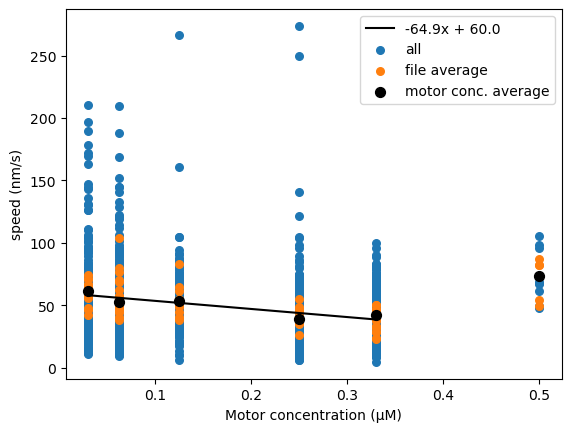

In [27]:
plt.scatter(df['motor conc'], df['speed (nm/s)'], s=30, label='all')
plt.scatter(file_group['motor conc'], file_group['speed (nm/s)'],s=30, label='file average')
plt.scatter(mot_group['motor conc'], mot_group['speed (nm/s)'], color='k', s=50, label='motor conc. average')
motconcfit = np.polyfit(mot_group['motor conc'][:-1], mot_group['speed (nm/s)'][:-1], deg=1)
plt.plot(mot_group['motor conc'][:-1], motconcfit[0]*mot_group['motor conc'][:-1] + motconcfit[1], 
         color='k', 
         label=str(round(motconcfit[0],1)) + 'x + ' + str(round(motconcfit[1],1)))
#plt.ylim(0, 100)
plt.legend()
plt.xlabel('Motor concentration (µM)')
plt.ylabel('speed (nm/s)')

Text(0, 0.5, 'speed (nm/s)')

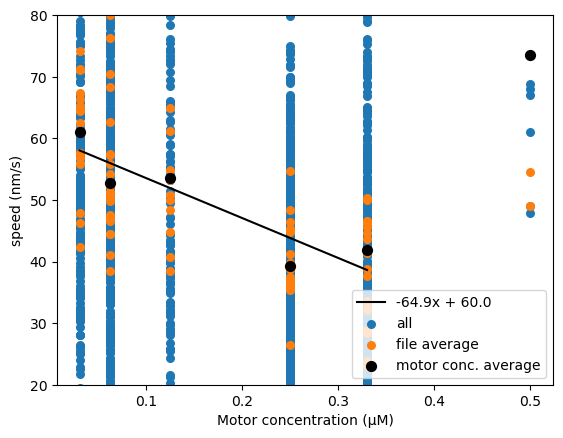

In [28]:
plt.scatter(df['motor conc'], df['speed (nm/s)'], s=30, label='all')
plt.scatter(file_group['motor conc'], file_group['speed (nm/s)'],s=30, label='file average')
plt.scatter(mot_group['motor conc'], mot_group['speed (nm/s)'], color='k', s=50, label='motor conc. average')
motconcfit = np.polyfit(mot_group['motor conc'][:-1], mot_group['speed (nm/s)'][:-1], deg=1)
plt.plot(mot_group['motor conc'][:-1], motconcfit[0]*mot_group['motor conc'][:-1] + motconcfit[1], 
         color='k', 
         label=str(round(motconcfit[0],1)) + 'x + ' + str(round(motconcfit[1],1)))
plt.ylim(20, 80)
plt.legend(loc='lower right')
plt.xlabel('Motor concentration (µM)')
plt.ylabel('speed (nm/s)')

## Speed vs Track Length

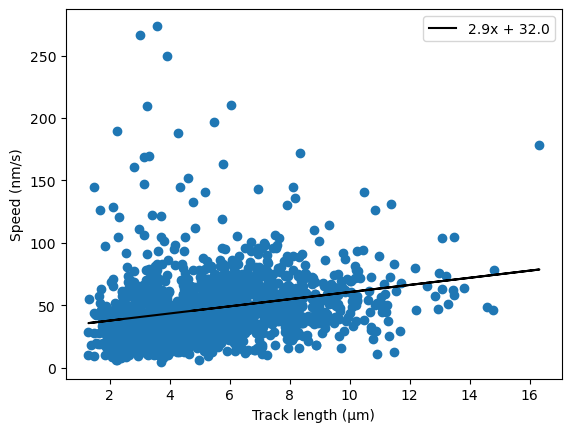

In [29]:
plt.scatter(df['major_axis_length']*umperpixel, df['speed (nm/s)'])
trackfit = np.polyfit(df['major_axis_length']*umperpixel, df['speed (nm/s)'], deg=1)
plt.plot(df['major_axis_length']*umperpixel, trackfit[0]*df['major_axis_length']*umperpixel + trackfit[1], 
         color='k', 
         label=str(round(trackfit[0],1)) + 'x + ' + str(round(trackfit[1],1)))

plt.xlabel('Track length (µm)')
plt.ylabel('Speed (nm/s)')
plt.legend()

## Speed vs Time

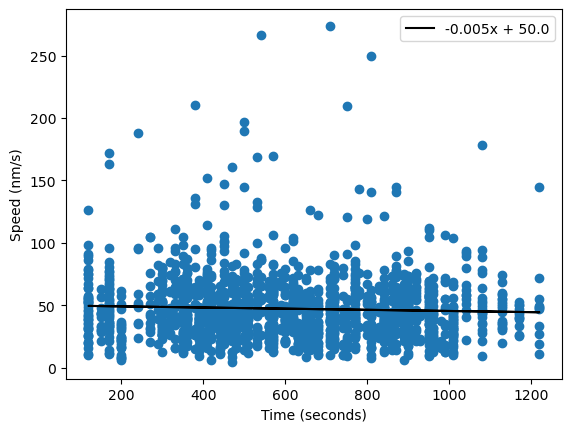

In [30]:
plt.scatter(df['time (seconds)'], df['speed (nm/s)'])
timefit = np.polyfit(df['time (seconds)'], df['speed (nm/s)'], deg=1)
plt.plot(df['time (seconds)'], timefit[0]*df['time (seconds)'] + timefit[1], 
         color='k', 
         label=str(round(timefit[0],3)) + 'x + ' + str(round(timefit[1],1)))

plt.xlabel('Time (seconds)')
plt.ylabel('Speed (nm/s)')
plt.legend()

# Speed vs. MT Length

In [31]:
for i, truthval in enumerate(np.isnan(df['MT len (um)'])):
    if truthval==True:
        df.loc[i, 'MT len (um)'] =0

In [32]:
def line(x, p0, p1):
    return p0 + p1*x

linemodel=lmfit.Model(line)
params = linemodel.make_params(p0=50, p1=-0.03)
fit = linemodel.fit(df['speed (nm/s)'], params, x= df['MT len (um)'])
coeffs = fit.best_values

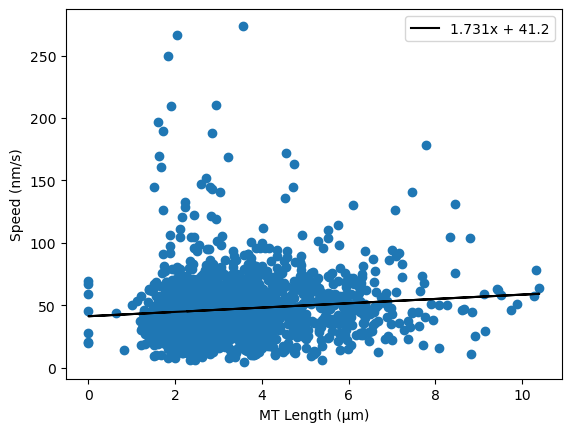

In [33]:
plt.scatter(df['MT len (um)'], df['speed (nm/s)'])
lenfit = np.polyfit(df['MT len (um)'], df['speed (nm/s)'], deg=1)
plt.plot(df['MT len (um)'], lenfit[0]*df['MT len (um)'] + lenfit[1], 
         color='k', 
         label=str(round(lenfit[0],3)) + 'x + ' + str(round(lenfit[1],1)))

plt.xlabel('MT Length (µm)')
plt.ylabel('Speed (nm/s)')
plt.legend()

# Side thing: python fits for MT length and speed vs by hand
(shown for all the MTs in '2023-07-10_Gliding_ATP1410um_2-start0_stop50')

In [34]:
byhand_file = pd.read_csv('../../analyzed_data/gliding/By-hand-compare_2023-07-10_Gliding_ATP1410um_2-start0_stop50.csv') 

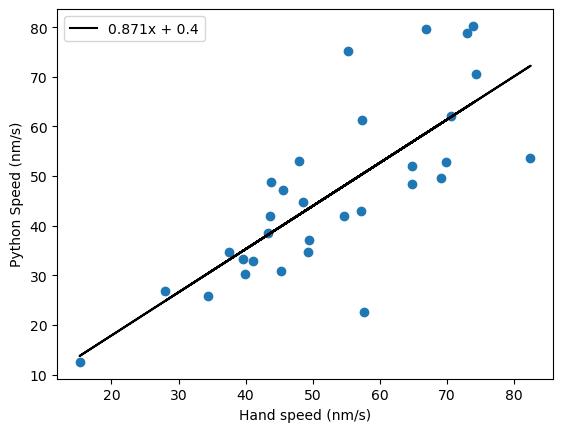

In [35]:
plt.scatter(byhand_file['hand speed (nm/s)'], byhand_file['speed (nm/s)'])
handspeedfit = np.polyfit(byhand_file['hand speed (nm/s)'], byhand_file['speed (nm/s)'], deg=1)
plt.plot(byhand_file['hand speed (nm/s)'], handspeedfit[0]*byhand_file['hand speed (nm/s)'] + handspeedfit[1], 
         color='k', 
         label=str(round(handspeedfit[0],3)) + 'x + ' + str(round(handspeedfit[1],1)))

plt.xlabel('Hand speed (nm/s)')
plt.ylabel('Python Speed (nm/s)')
plt.legend()

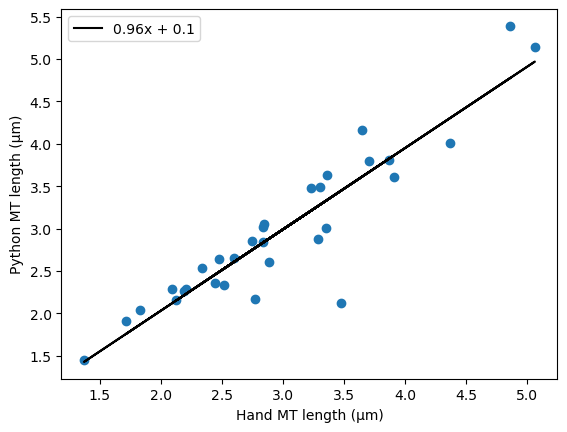

In [36]:
plt.scatter(byhand_file['hand length (um)'], byhand_file['MT len (um)'])
handlenfit = np.polyfit(byhand_file['hand length (um)'], byhand_file['MT len (um)'], deg=1)
plt.plot(byhand_file['hand length (um)'], handlenfit[0]*byhand_file['hand length (um)'] + handlenfit[1], 
         color='k', 
         label=str(round(handlenfit[0],3)) + 'x + ' + str(round(handlenfit[1],1)))

plt.xlabel('Hand MT length (µm)')
plt.ylabel('Python MT length (µm)')
plt.legend()

# Number of events

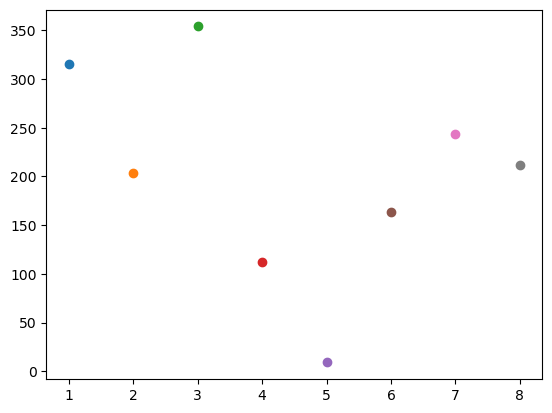

In [37]:
for i, g in enumerate(np.unique(df['group'])):
    plt.scatter(g, len(df[df['group']==g]))

In [38]:
num_files_pergroup = [len(group1), len(group2), len(group3), len(group4), len(group5), len(group6), len(group7), len(group8)]

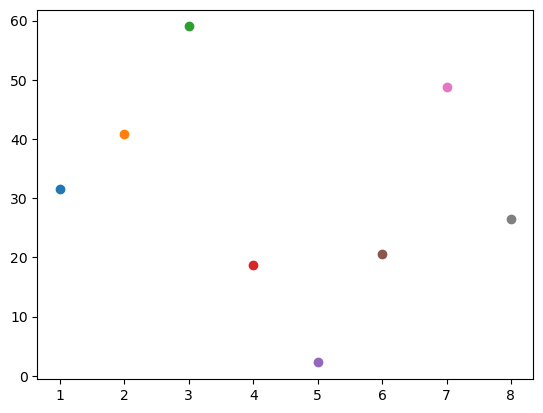

In [39]:
for i, g in enumerate(np.unique(df['group'])):
    plt.scatter(g, len(df[df['group']==g])/num_files_pergroup[i])

In [40]:
len(df['group'])

1614

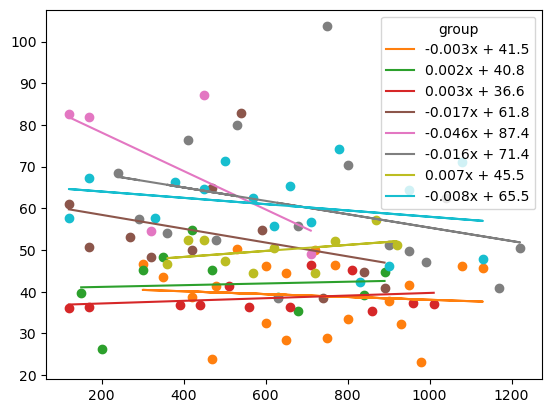

In [20]:
# setup the normalization and the colormap
groups = np.unique(df['group'])
normalize = mcolors.Normalize(vmin=0, vmax=groups.max())
colormap = cm.tab10

scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array([0.125, 0.25, 0.33, 0.5])
for i in groups:
    tempdf = file_group.loc[file_group['group']==i]
    plt.scatter(tempdf['time (seconds)'], tempdf['speed (nm/s)'], color = colormap(normalize(i)))
    
    tempfit = np.polyfit(tempdf['time (seconds)'], tempdf['speed (nm/s)'], deg=1)
    plt.plot(tempdf['time (seconds)'], tempfit[0]*tempdf['time (seconds)'] + tempfit[1], 
         color=colormap(normalize(i)), 
         label=str(round(tempfit[0],3)) + 'x + ' + str(round(tempfit[1],1)))
plt.legend(title='group')

In [21]:
file_group

,file_name,major_axis_length,minor_axis_length,centroid-0,centroid-1,orientation,speed (nm/s),r^2,skele r^2,MT len (um),motor conc,MT dilute,time (seconds),group
0,2023-07-10_Gliding_ATP1410um_10-start0_stop50.csv,21.545920,1.399342,266.171343,267.308824,0.052388,28.959474,0.919589,0.841718,2.439717,0.3300,2000.0,750.0,1.0
1,2023-07-10_Gliding_ATP1410um_10-start50_stop10...,30.074794,1.734978,322.633435,168.847039,-0.693990,33.538508,0.965885,0.694016,3.596608,0.3300,2000.0,800.0,1.0
2,2023-07-10_Gliding_ATP1410um_11-start0_stop50.csv,21.958002,1.335684,241.284091,258.345238,-0.876301,32.192165,0.929130,0.828184,2.549906,0.3300,2000.0,930.0,1.0
3,2023-07-10_Gliding_ATP1410um_11-start50_stop10...,18.279487,1.026573,260.750000,201.650000,-0.399397,23.037419,0.905296,0.818535,2.640011,0.3300,2000.0,980.0,1.0
4,2023-07-10_Gliding_ATP1410um_2-start0_stop50.csv,32.740434,2.719092,226.508575,238.991568,0.062896,46.638085,0.933226,0.832337,2.967573,0.3300,2000.0,300.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1...,47.318178,2.425807,304.640377,329.159805,0.201876,76.351965,0.907807,0.827945,4.943066,0.0625,50.0,410.0,6.0
96,2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1...,34.466554,3.287728,346.392718,252.316625,0.240061,52.479611,0.919099,0.792261,3.598546,0.0625,50.0,480.0,6.0
97,2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1...,40.298943,4.953506,240.184661,267.477893,-0.038117,80.005298,0.918801,0.654069,4.074076,0.0625,50.0,530.0,6.0
98,2023-08-11_Gliding_0.0625uM-NCDiLidYFP-50-MT-1...,29.034711,2.729982,303.904458,186.602774,0.557057,68.397105,0.887362,0.826832,3.231469,0.0625,50.0,240.0,6.0
